In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
import pandas as pd
import numpy as np
import seaborn as sns
import os
import csv

import cv2

from glob import glob
from matplotlib.patches import  Polygon
from matplotlib.collections import PatchCollection
from matplotlib.lines import Line2D
from scipy.stats import linregress
from scipy.spatial.distance import cdist
from scipy.linalg import polar
from scipy import optimize

import sys
sys.path.insert(0, "..")

from utils import fileio
from utils import handtrace
from utils import matrices
from utils import geometry
from utils import mechanics
from utils import visualise

In [3]:

    Lambda = -0.259 # Line tension (tunes P_0) (non-dimensional)
    Gamma = 0.172  # Contractility (non-dimensional)
    pref_perimeter  = -Lambda/(2*Gamma) 

In [55]:
pref_perimeter

0.7529069767441862

In [4]:
def make_polygon(i, C, R, cell_centres):
    """
    Generate polygon

    Parameters:
    i (int): cell id
    C (numpy array): Nc x Nv order array relating cells to vertices
    R (numpy array): vertex coordinates
    cell_centres (numpy array): cell centre coordinates
    """

    Ralpha=R[np.where(C[i,:]==1)[0]]-cell_centres[i] #ref frame of cell
    ang=np.arctan2(Ralpha[:,1], Ralpha[:,0])%(2*np.pi) #find angle with x axis
    R_ang=np.transpose(np.vstack((np.where(C[i,:]==1)[0], ang))) #stack index of vertices with angle
    ordered_vertices=R_ang[np.argsort(R_ang[:,-1], axis=0)] #sort by anticlockwise angle
    polygon = Polygon(R[ordered_vertices[:,0].astype(int)],closed = True)
    return polygon

def plot_edges(A, R, color):
    N_e=np.shape(A)[0]
    beg_edge = ((abs(A) - A)*0.5)@R
    end_edge = ((abs(A) + A)*0.5)@R
    for j in range(0,N_e):
        plt.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c=color,alpha=1.0,linestyle ='-')

def plot_cell_centres(cell_centres, color):
    for i in range(len(cell_centres)):
        plt.plot(cell_centres[i,0],cell_centres[i,1],marker ='o',markersize=2, c=color)
        
def plot_cell_id(cell_centres):
    for i in range(len(cell_centres)):
        plt.text(cell_centres[i][0], cell_centres[i][1], str(i),fontsize= 5,color='w', horizontalalignment='center', verticalalignment='center')

def plot_alignment_axis(cell_centres,alignment_axis):
    for i in range(len(cell_centres)):
            plt.quiver(cell_centres[i,0],cell_centres[i,1],np.cos(alignment_axis)[i],np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)
            plt.quiver(cell_centres[i,0],cell_centres[i,1],-np.cos(alignment_axis)[i],-np.sin(alignment_axis)[i],facecolor = 'black',scale=110,width=0.002,headwidth=0.0,headlength=0.0,headaxislength=0.0)



def plot_polys(C, R, cell_centres):
    N_c=np.shape(C)[0]
    patches = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)

    p = PatchCollection(patches,alpha = 1.0)
    return p

def plot_binary_polys(C, R, cell_centres, plot_var, threshold):
    N_c=np.shape(C)[0]
    patches = []
    patchesLow = []
    patchesHigh = []

    for i in range(N_c):
        polygon = make_polygon(i, C, R, cell_centres)
        patches.append(polygon)
        
        if plot_var[i] < threshold:
            polygonLow = polygon
            patchesLow.append(polygonLow)
        else:
            polygonHigh = polygon
            patchesHigh.append(polygonHigh)


    ### For binary effective pressure
    p_low = PatchCollection(patchesLow,alpha = 0.5)
    p_high = PatchCollection(patchesHigh,alpha = 0.7)
   
    return p_low, p_high

In [124]:
CURRENT_DIR = os.getcwd()
input_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\unstretched/Tracked/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces/'
save_dir='C:\\Users\\v35431nc\\Documents\\Lab_Stuff\\Movies_to_track\\Output/pref_area_test/'

tr_files=sorted(glob(input_dir+'*_trace.tif'))[:]
#for f in tr_files:
f=tr_files[0]
print(f)
edges_name=f.split('\\')[-1].split('.')[0]
exp_id=edges_name.split('_')[0]+'_'+edges_name.split('_')[1]+'_'+edges_name.split('_')[7]

print("Extracing trace data")
edge_verts,cells, cell_edges, A, B, C, R, image0 = handtrace.run_trace(edges_name, input_dir)
#handtrace.check_trace_plot(save_dir,image0, cells, R, edges_name)

micron_size=553.57
pixel_size=1024


C:\Users\v35431nc\Documents\Lab_Stuff\Movies_to_track\unstretched/Tracked/20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP/5min_int/traces\20240117_2_IP_GFPCAAX-CheHis_uu_0p5_SP_fr001_trace.tif
Extracing trace data
838 1215 378


In [5]:
t=0

In [125]:
    R=R*(micron_size/pixel_size)

    cell_areas=geometry.get_areas(A,B, R)
    cell_perimeters=geometry.get_perimeters(A,B,R)
    cell_edge_count=geometry.get_edge_count(B)
    cell_centres=geometry.get_cell_centres(C,R,cell_edge_count)
    mean_cell_area=geometry.get_mean_area(cell_areas)

    N_c=len(cell_areas)

In [126]:
pref_area_P=geometry.get_pref_area(cell_areas, Gamma, cell_perimeters, pref_perimeter, mean_cell_area)
print("Prefered area = ", pref_area_P)

Prefered area =  1619.3519518479056


In [34]:
optimize.minimize(mechanics.GlobalStress,args=(cell_areas, Gamma, cell_perimeters, pref_perimeter),  x0=mean_cell_area)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -8.867209520767165
        x: [ 5.256e+05]
      nit: 14
      jac: [-8.583e-06]
 hess_inv: [[ 2.200e+10]]
     nfev: 44
     njev: 22

In [127]:
tangents=geometry.get_tangents(A,R)
edge_lengths=geometry.get_edge_lengths(tangents)
Q,J=mechanics.get_Q_J(tangents, edge_lengths, B,cell_perimeters)

In [9]:
np.linalg.det(np.linalg.inv(np.sum((pref_perimeter*cell_perimeters)[:, None, None]*J, axis=0))@np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))



11492.75605978718

In [10]:
pref_area_T=np.linalg.det(np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))/((pref_perimeter*pref_perimeter)*np.linalg.det(np.sum((cell_perimeters)[:, None, None]*J, axis=0)))
print("Prefered area = ", pref_area_T)

Prefered area =  11492.756059787213


In [145]:
T_func(pref_area_P, cell_perimeters, pref_perimeter, J)

array([[ 483.32892774,  198.77226494],
       [ 198.77226494, -483.32892774]])

In [149]:
def T_func(A0, L, L0, J):
    return np.sum(((L*L)/np.sqrt(A0) - L0*L)[:, None, None]*J, axis=0)

def T_obj(A0, L, L0, J):

    res = np.sqrt(-np.linalg.det(T_func(A0, L, L0, J)))
    return res 



In [151]:
optimize.minimize(T_obj, x0=pref_area_P, args=(cell_perimeters, pref_perimeter, J), bounds=optimize.Bounds(lb=0, ub=20000), method='trust-constr', constraints=[nlcP, nlcT])

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 604.452208646782
                 x: [ 1.353e+03]
               nit: 372
              nfev: 734
              njev: 367
              nhev: 0
          cg_niter: 368
      cg_stop_cond: 1
              grad: [-3.520e-01]
   lagrangian_grad: [-2.115e-09]
            constr: [array([ 1.448e-01,  1.594e-01, ...,  3.735e-01,
                            5.346e-01]), array([ 1.555e+00,  1.642e+00, ...,  2.358e+00,
                            2.745e+00]), array([ 1.353e+03])]
               jac: [array([[-1.070e-04],
                           [-1.178e-04],
                           ...,
                           [-2.760e-04],
                           [-3.951e-04]]), array([[-5.745e-04],
                           [-6.069e-04],
                           ...,
                           [-8.716e-04],
                           [-1.014e-03]]), array([[ 1.000e+0

In [160]:
minimizer_kwargs = {"method":"trust-constr"}

optimize.shgo(T_obj,bounds=optimize.Bounds(lb=1, ub=20000), args=(cell_perimeters, pref_perimeter, J), minimizer_kwargs=minimizer_kwargs, constraints=[nlcP, nlcT], sampling_method='sobol')



 message: Optimization terminated successfully.
 success: True
     fun: 604.4522008140616
    funl: [ 6.045e+02]
       x: [ 1.353e+03]
      xl: [[ 1.353e+03]]
     nit: 1
    nfev: 98
   nlfev: 94
   nljev: 47
   nlhev: 0

In [115]:
def func(A, L, L_0, J):
    f=(1/A)*np.linalg.det(np.sum((L*L)[:, None, None]*J, axis=0))-(L_0*L_0)*np.linalg.det(np.sum(L[:, None, None]*J, axis=0))

    return f

def d_func(A, L, L_0, J):
    df=-(1/(A*A))*np.linalg.det(np.sum((L*L)[:, None, None]*J, axis=0))

    return df

In [116]:
def force_sum(A0, Ai, Li, dAdr, dLdr, Gamma, L0):
    return np.linalg.norm(np.sum((1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1), axis=0))

def dforce_sum(A0, Ai, Li, dAdr, dLdr, Gamma, L0):
    return np.linalg.norm(np.sum((-3*np.tensordot((Ai), dAdr, axes=1) + A0*(np.tensordot(np.zeros_like(Ai), dAdr, axes=1)-np.tensordot(Gamma*(Li), dLdr, axes=1)))/(2*(A0**(-5/2))) , axis=0))

In [117]:
def GlobalStress(theta, A, Gamma, L, L_0):
    """GlobalsStress of the cells as a function of cell area"""
    pref_area, Pext=theta
    globalStress = np.sum(((A/pref_area) - 1 + 0.5*Gamma*(L/A)*(L - L_0*(pref_area**(1/2))))*A)/np.sum(A) - Pext;
    return globalStress;

def derivative_GlobalStress(theta, A, Gamma, L, L_0):
    """first derivative of global stress of the cells as a function of cell area"""
    pref_area, Pext=theta
    d_globalStress = np.sum((-(A/(pref_area**2))- 0.25*Gamma*(L/A)*(L_0*(pref_area**(-1/2))))*A)/np.sum(A);
    return d_globalStress;

In [414]:
optimize.least_squares(GlobalStress,x0=[1000, -0.01], args=(cell_areas, Gamma, cell_perimeters, pref_perimeter))

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-2.239e-06]
           x: [ 1.000e+03  2.452e-01]
        cost: 2.507565892884708e-12
         jac: [[-5.914e-04 -1.000e+00]]
        grad: [ 1.324e-09  2.239e-06]
  optimality: 2.239448991553372e-06
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 26
        njev: 9

In [118]:
def GStress(A0, A, Gamma, L, L0):
    """GlobalsStress of the cells as a function of cell area"""

    globalStress = np.sum((A/A0)*((A/A0)-1)+ ((Gamma*L)/(2*np.sqrt(A0)) )*((L/np.sqrt(A0))-L0) )/np.sum(A/A0);
    return globalStress;

def GStress_ext(theta, A, Gamma, L, L0):
    """GlobalsStress of the cells as a function of cell area"""
    A0, Pext=theta
    globalStress = np.sum(A*((A/A0)-1)+ (Gamma*L*np.sqrt(A0))/(2*A)*((L/np.sqrt(A0))-L0))-Pext*np.sum(A);
    return globalStress;

def dGStress(A0, A, Gamma, L, L0):
    dgs=np.sum(-(8*A**2 + 4*A*A0 +A0*L*(-2*L-A0*L0)*Gamma)/(4*A0**3))/np.sum(A/A0) + np.sum((A/A0)*((A/A0)-1)+ ((Gamma*L)/(2*np.sqrt(A0)) )*((L/np.sqrt(A0))-L0) ) *np.sum(A)
    return dgs

In [119]:
optimize.least_squares(GStress_ext,x0=[1000, 0], args=(cell_areas, Gamma, cell_perimeters, pref_perimeter))

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 9.677e-01]
           x: [ 1.000e+03 -5.853e-01]
        cost: 0.4682648468441437
         jac: [[-6.908e+01 -1.672e+05]]
        grad: [-6.685e+01 -1.618e+05]
  optimality: 161848.415230727
 active_mask: [ 0.000e+00  0.000e+00]
        nfev: 29
        njev: 11

In [396]:
ls_dGS=optimize.least_squares(GStress,x0=[1000], args=(cell_areas, Gamma, cell_perimeters, pref_perimeter))

In [360]:
optimize.fsolve(dGStress,x0=[1000], args=(cell_areas, Gamma, cell_perimeters, pref_perimeter))

array([1674.93873668])

In [120]:
conT = lambda x: cell_perimeters/np.sqrt(x[0]) - pref_perimeter

nlcT = optimize.NonlinearConstraint(conT,0,np.inf)

# conP=lambda x: cell_areas/x[0] -1
# nlcP=optimize.NonlinearConstraint(conP,0,1)

sol = optimize.minimize(GStress_ext,args=(cell_areas, Gamma, cell_perimeters, pref_perimeter),  x0=(mean_cell_area, 0), bounds=bnds,constraints=nlcP,method='trust-constr')
sol

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: -3196466994311891.0
                 x: [ 2.761e+01  1.911e+10]
               nit: 1000
              nfev: 3000
              njev: 1000
              nhev: 0
          cg_niter: 1805
      cg_stop_cond: 1
              grad: [ 0.000e+00 -1.672e+05]
   lagrangian_grad: [ 1.020e+00 -1.672e+05]
            constr: [array([ 7.732e-01,  9.692e+00, ...,  1.319e+01,
                            2.519e+01]), array([ 2.761e+01,  1.911e+10])]
               jac: [array([[-6.423e-02,  0.000e+00],
                           [-3.873e-01,  0.000e+00],
                           ...,
                           [-5.139e-01,  0.000e+00],
                           [-9.487e-01,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [3000, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0

In [412]:
sol = optimize.minimize(GStress,args=(cell_areas, Gamma, cell_perimeters, pref_perimeter),  x0=(mean_cell_area), constraints=nlc, method='trust-constr')

sol

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: -0.14306459296128002
                 x: [ 2.109e+03]
               nit: 1000
              nfev: 2018
              njev: 1009
              nhev: 0
          cg_niter: 995
      cg_stop_cond: 1
              grad: [-2.279e-04]
   lagrangian_grad: [-1.945e-04]
            constr: [array([ 4.652e-01,  9.227e-01, ...,  1.047e+00,
                            1.110e+00])]
               jac: [array([[-2.888e-04],
                           [-3.973e-04],
                           ...,
                           [-4.268e-04],
                           [-4.418e-04]])]
       constr_nfev: [2018]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-3.442e-04, -1.735e-04, ..., -1.529e-04,
                           -1.442e-04])]
            method: tr_interior_point
        optimality: 0.00019445791375817252
  constr_violation

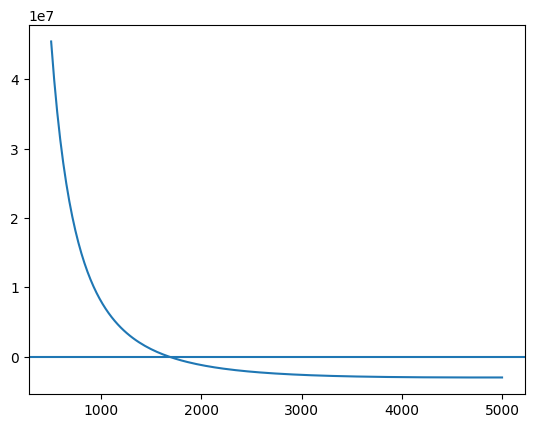

In [372]:
pts=np.linspace(500, 5000, 150)
plt.plot(pts,np.array([dGStress(x, cell_areas, Gamma, cell_perimeters, pref_perimeter)for x in pts]))
plt.axhline()

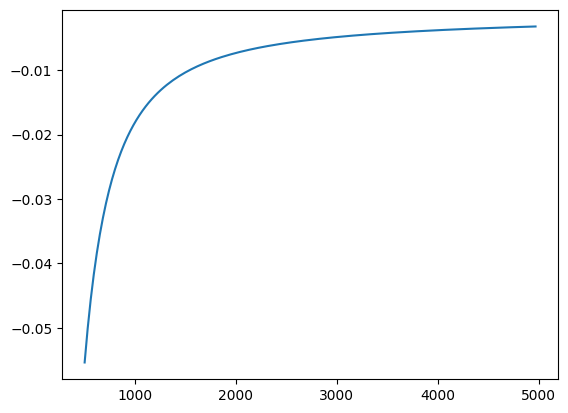

In [374]:
pts=np.linspace(500, 5000, 150)
plt.plot(pts[:-1],np.diff(np.array([GStress(x, cell_areas, Gamma, cell_perimeters, pref_perimeter)for x in pts])))

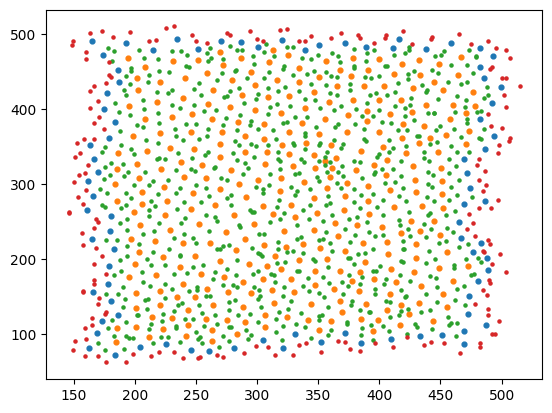

In [128]:
int_verts=np.ones(len(R))-0.5*(abs(np.ones(N_c)@B))@abs(A)
ext_verts=0.5*(abs(np.ones(N_c)@B))@abs(A)
bool_iv=int_verts==1
bool_ev=ext_verts==1
edgecells=np.unique(np.where(C[:, bool_ev]!=0)[0])
intcells=np.array(list(set(np.linspace(0, N_c-1, N_c).astype(int)).difference(edgecells)))
#plt.scatter(cell_centres[:,0], cell_centres[:, 1])
plt.scatter(cell_centres[edgecells,0], cell_centres[edgecells, 1], s=12)
plt.scatter(cell_centres[intcells,0], cell_centres[intcells, 1],s=12)

plt.scatter(R[bool_iv,0], R[bool_iv, 1], s=5)
plt.scatter(R[bool_ev,0], R[bool_ev, 1], s=5)

In [26]:
sol = optimize.root_scalar(func,args=(cell_perimeters[intcells], pref_perimeter, J[intcells]),  x0=mean_cell_area, fprime=d_func, method='newton')
pref_area_newton=sol.root
sol

NameError: name 'func' is not defined

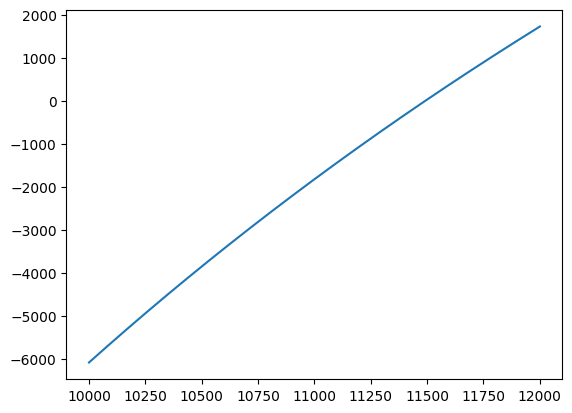

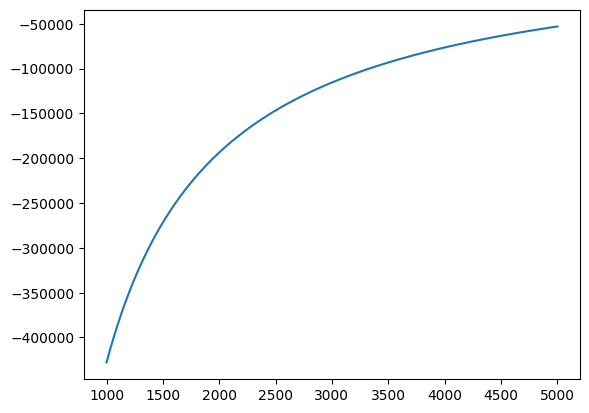

In [283]:
plt.plot(np.linspace(10000, 12001, 2000),func(np.linspace(10000, 12001, 2000),cell_perimeters, pref_perimeter, J))

plt.show()
plt.plot(np.linspace(1000, 5001, 2000),func(np.linspace(1000, 5001, 2000),cell_perimeters, pref_perimeter, J))


In [400]:
    sol = optimize.root_scalar(func,args=(cell_perimeters, pref_perimeter, J),  x0=mean_cell_area, fprime=d_func, method='newton')
    #pref_area=sol.root
    sol

      converged: True
           flag: converged
 function_calls: 22
     iterations: 11
           root: 10563.349832026792

In [129]:
N_c=len(cell_areas)
N_e=len(edge_lengths)
nij=geometry.get_normals(B,tangents, N_c, N_e)
dAdr=geometry.get_dAdr(A, nij)
dLdr=geometry.get_dLdr(A, B, tangents, edge_lengths)

In [100]:
R.shape

(993, 2)

In [104]:
np.tensordot((cell_areas[intcells] -1), dAdr[:,bool_iv][intcells], axes=1).shape

(812, 2)

In [11]:
def fstar(A0, Ai, Li, dAdr, dLdr, Gamma, L0):
    return (1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1)

In [68]:
np.sum((cell_areas[:, None, None]-1)*dAdr, axis=1)

array([[-1.42108547e-14,  0.00000000e+00],
       [-2.27373675e-13,  0.00000000e+00],
       [ 0.00000000e+00,  2.27373675e-13],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.13686838e-13,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.13686838e-13,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-8.52651283e-14,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-5.68434189e-14,  0.00000000e+00],
       [ 1.42108547e-13,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 6.82121026e-13, -4.54747351e-13],
       [ 6.82121026e-13,  9.09494702e-13],
       [-4.54747351e-13, -4.54747351e-13],
       [ 1.

In [61]:
dAdr.shape

(436, 955, 2)

In [403]:
f_test=fstar(pref_area_P, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_test2=fstar(pref_area, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_newton=fstar(pref_area_newton, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)

In [14]:
f_test=fstar(pref_area_P, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)


In [18]:
[np.dot(f, f) for f in f_test]

[0.0021979523280289143,
 0.0011495015025159618,
 0.005035817956902503,
 7.043278289905081e-05,
 0.021419829640110324,
 0.002811286891538263,
 0.03831696063696852,
 0.0016434956945810294,
 0.019605019058904542,
 0.0012995729476997099,
 9.144349289966283e-05,
 0.0033105933068995996,
 0.0006359407080128331,
 0.0006807491539865448,
 0.006199545520912076,
 0.0024420250030831067,
 0.008010201252162383,
 0.0037272449937064867,
 0.00034185561567608754,
 0.01840659547327716,
 0.00036279597479503485,
 0.00012720205593608094,
 0.006724189331301707,
 0.008963391465725076,
 0.004690938797231844,
 0.0030378910781097526,
 0.004391495705780013,
 0.010018493516177314,
 0.0014168237717211221,
 0.010225939483322191,
 0.001329439610436812,
 0.000805148227850908,
 0.0021883165231847816,
 0.02233718227511425,
 0.00507114416368619,
 0.006032413517385986,
 0.009846922143026597,
 0.009839851761495983,
 0.00780623018487648,
 0.005812872889894857,
 0.003139903074980938,
 0.004265079228594736,
 0.0157735650624489

In [452]:

f_fit=fstar(result.x[0],cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_ev=fstar(result2.x[0],cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_lim=fstar(result_lim.x[0],cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_const=fstar(res_const.x[0],cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_Peff=fstar(sol.x,cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter )
f_fit_P_cons=fstar(res_P_cons.x,cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter )

ValueError: operands could not be broadcast together with shapes (452,) (2,) 

(array([  6.,  23.,  87., 160., 143.,  80.,  21.,   8.,   0.,   1.]),
 array([  27.47090914,  136.53626329,  245.60161744,  354.6669716 ,
         463.73232575,  572.7976799 ,  681.86303406,  790.92838821,
         899.99374236, 1009.05909652, 1118.12445067]),
 <BarContainer object of 10 artists>)

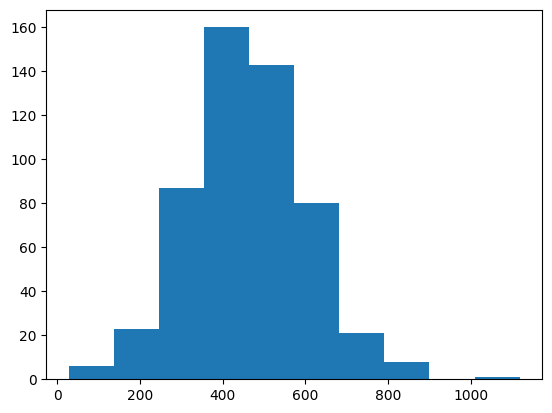

In [322]:
plt.hist(cell_areas)

(array([23., 91., 99., 82., 31., 20., 17.,  9.,  3.,  3.]),
 array([3.68438739, 3.74451718, 3.80464697, 3.86477676, 3.92490655,
        3.98503634, 4.04516613, 4.10529592, 4.16542571, 4.2255555 ,
        4.28568529]),
 <BarContainer object of 10 artists>)

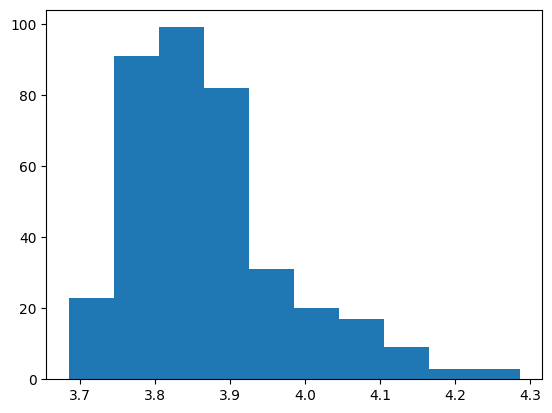

In [167]:
plt.hist(cell_perimeters/np.sqrt(cell_areas))

(array([ 13.,  26.,  78., 167., 160., 136.,  60.,  21.,   5.,   4.]),
 array([ 3.96020042,  7.79006979, 11.61993916, 15.44980854, 19.27967791,
        23.10954728, 26.93941665, 30.76928602, 34.59915539, 38.42902477,
        42.25889414]),
 <BarContainer object of 10 artists>)

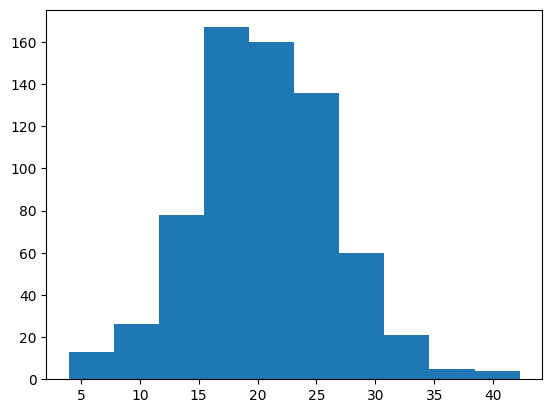

In [166]:
plt.hist(np.sqrt(np.linalg.norm(np.tensordot(cell_areas,dAdr[:, bool_iv], axes=1), axis=1)))

In [349]:
((np.min(cell_perimeters)**2)/pref_perimeter)**2

572583.8151805429

(array([128., 254., 238., 177.,  88.,  46.,  17.,   6.,   5.,   1.]),
 array([  3.33432053,  19.51710419,  35.69988785,  51.88267151,
         68.06545517,  84.24823883, 100.43102249, 116.61380615,
        132.79658981, 148.97937347, 165.16215713]),
 <BarContainer object of 10 artists>)

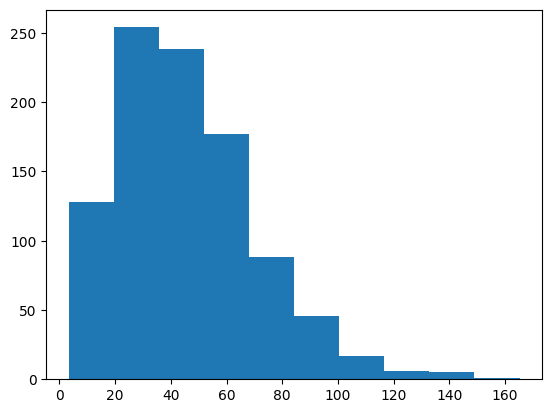

In [339]:
plt.hist(np.linalg.norm(np.tensordot(cell_perimeters,dLdr[:, bool_iv], axes=1), axis=1))

NameError: name 'f_subset2' is not defined

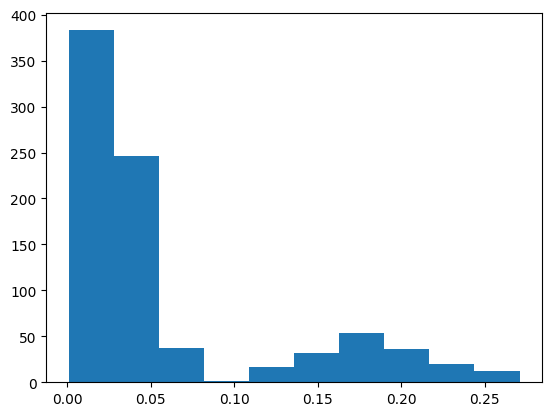

In [177]:
plt.hist(np.linalg.norm(f_fit, axis=1))
plt.hist(np.linalg.norm(f_subset2, axis=1), alpha=0.5)
plt.hist(np.linalg.norm(f_subset, axis=1), alpha=0.5)

NameError: name 'f_fit_P_cons' is not defined

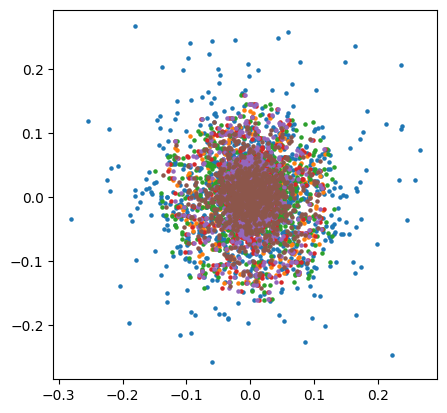

In [453]:
fig, ax=plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(f_test[:, 0], f_test[:,1], s=5)
#ax.scatter(f_test[bool_iv][:, 0], f_test[bool_iv][:,1], s=5)
#ax.scatter(f_subset2[:, 0], f_subset2[:,1], s=5)
ax.scatter(f_fit[:, 0], f_fit[:,1], s=5)
ax.scatter(f_fit_ev[:, 0], f_fit_ev[:,1], s=5)
ax.scatter(f_newton[:, 0], f_fit_ev[:,1], s=5)
ax.scatter(f_fit_lim[:, 0], f_fit_ev[:,1], s=5)
ax.scatter(f_fit_const[:, 0], f_fit_const[:,1], s=5)
ax.scatter(f_fit_P_cons[:, 0], f_fit_Peff[:,1], s=5)

In [ ]:
plt.plot(object)

In [93]:
(np.linalg.norm(f_test, axis=1)**2).sum()

16.979579505576968

In [94]:
(f_test**2).sum()

16.979579505576968

In [19]:
def objective(A0,Ai, Li, dAdr, dLdr, Gamma, L0):

    res = np.linalg.norm(fstar(A0,Ai, Li, dAdr, dLdr, Gamma, L0)).sum()
    return res 

def objective_sq(A0,Ai, Li, dAdr, dLdr, Gamma, L0):
    fk=fstar(A0,Ai, Li, dAdr, dLdr, Gamma, L0)
    res = np.array([np.dot(f, f) for f in fk]).sum()
    return res 

In [125]:
def objective_all(theta,Ai, Li, dAdr, dLdr):

    A0, Gamma, L0=theta

    res = np.linalg.norm(fstar(A0,Ai, Li, dAdr, dLdr, Gamma, L0)).sum()
    return res 

In [20]:
conT= lambda x: cell_perimeters/np.sqrt(x)
nlcT = optimize.NonlinearConstraint(conT,pref_perimeter,np.inf)

conP=lambda x: cell_areas/x 
nlcP=optimize.NonlinearConstraint(conP,0,1)

# conT_all = lambda x: cell_perimeters[intcells]/np.sqrt(x[0]) - x[2]
# conP_all = lambda x: cell_areas[intcells]/x[0] -1

# nlcT_all = optimize.NonlinearConstraint(conT_all,0,np.inf)
# nlcP_all = optimize.NonlinearConstraint(conP_all,0,np.inf)

In [162]:
optimize.minimize(objective_sq, x0=1000, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], 0.5, 2),bounds=optimize.Bounds(lb=0, ub=np.inf), constraints=[nlcP, nlcT])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 46.83031493731927
       x: [ 1.201e+03]
     nit: 10
     jac: [-1.049e-05]
    nfev: 20
    njev: 10

In [24]:
optimize.minimize(objective, x0=1000, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=20000)).xpref_area_fk=

In [161]:
optimize.minimize(objective_sq, x0=1000, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),bounds=optimize.Bounds(lb=0, ub=20000))

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 2.106736483017184
        x: [ 7.135e+03]
      nit: 12
      jac: [-9.726e-06]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

In [25]:
pref_area_fk_gloe=optimize.direct(objective,bounds=optimize.Bounds(lb=0, ub=10000), args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter),maxfun=100000, maxiter=100000).x

In [88]:
optimize.dual_annealing(objective,bounds=optimize.Bounds(lb=0, ub=10000), args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter), maxiter=100000)

 message: ['Maximum number of iteration reached']
 success: True
  status: 0
     fun: 1.4872206178172662
       x: [ 7.159e+03]
     nit: 100000
    nfev: 454075
    njev: 126997
    nhev: 0

In [134]:
optimize.differential_evolution(objective_all, bounds=optimize.Bounds([0.,0.,0.], [10000.,10., 3.81 ]), args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells]))

 message: Optimization terminated successfully.
 success: True
     fun: 0.964505464346435
       x: [ 9.997e+03  6.644e-02  1.168e-01]
     nit: 20
    nfev: 1001
     jac: [-4.398e-05  2.622e-05 -5.507e-06]

In [255]:
res_const_all=optimize.minimize(objective_all, x0=[1000,1,1], args=( cell_areas, cell_perimeters, dAdr[:, bool_iv], dLdr[:, bool_iv]), constraints=nlc_all, method='trust-constr')

C:\Users\v35431nc\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [405]:
res_const

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.2958291466191867
                 x: [ 4.240e+03]
               nit: 197
              nfev: 392
              njev: 196
              nhev: 0
          cg_niter: 190
      cg_stop_cond: 1
              grad: [-3.081e-04]
   lagrangian_grad: [-1.005e-09]
            constr: [array([ 1.061e-01,  4.287e-01, ...,  5.162e-01,
                            5.608e-01]), array([ 4.240e+03])]
               jac: [array([[-1.013e-04],
                           [-1.393e-04],
                           ...,
                           [-1.497e-04],
                           [-1.549e-04]]), array([[ 1.000e+00]])]
       constr_nfev: [392, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-6.033e-05, -1.493e-05, ..., -1.240e-05,
                           -1.141e-05]), array([-1.509e-09])]
            method: tr_interior_point
       

In [406]:
result=optimize.minimize(objective, x0=np.max(cell_areas), args=( cell_areas, cell_perimeters, dAdr[:, bool_iv], dLdr[:, bool_iv], Gamma, pref_perimeter), bounds=bnds, method='trust-constr')

In [407]:
result2=optimize.minimize(force_sum, x0=np.max(cell_areas), args=( cell_areas, cell_perimeters, dAdr[:, bool_ev], dLdr[:, bool_ev], Gamma, pref_perimeter), method='trust-constr')

In [408]:
result_lim=optimize.minimize(objective, x0=np.max(cell_areas), args=( cell_areas[(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], cell_perimeters[(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], dAdr[:,bool_iv][(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], dLdr[:,bool_iv][(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], Gamma, pref_perimeter), bounds=bnds, method='trust-constr')

In [409]:
result_lim_c=optimize.minimize(objective, x0=np.max(cell_areas), args=( cell_areas[(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], cell_perimeters[(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], dAdr[:,bool_iv][(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], dLdr[:,bool_iv][(cell_areas<np.mean(cell_areas)+2*np.std(cell_areas))&(cell_areas>np.mean(cell_areas)-2*np.std(cell_areas))], Gamma, pref_perimeter), constraints=nlc,bounds=bnds, method='trust-constr')

In [464]:
optimize.minimize(objective, x0=np.max(cell_areas), args=( cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter), bounds=bnds, constraints=[nlc, nlcP], method='COBYLA')

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 42.92709999044108
       x: [ 1.490e+02]
    nfev: 607
   maxcv: 2.5174213824641356e-09

In [478]:
minimizer_kwargs = {"method":"trust-constr"}
optimize.shgo(objective, args=( cell_perimeters, , bounds=optimize.Bounds(lb=0.01, ub=np.inf), minimizer_kwargs=minimizer_kwargs, constraints=[nlc])

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_6032\2784156025.py:1: RuntimeWarning: divide by zero encountered in divide
  con = lambda x: cell_perimeters/np.sqrt(x) - pref_perimeter


 message: Optimization terminated successfully.
 success: True
     fun: 22219550.43402469
    funl: [ 2.222e+07]
       x: [ 2.225e-02]
      xl: [[ 2.225e-02]]
     nit: 1
    nfev: 3983
   nlfev: 3982
   nljev: 1991
   nlhev: 0

In [455]:
optimize.minimize(objective, x0=np.max(cell_areas), args=( cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter), bounds=bnds, constraints=nlc, method='trust-constr')

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.7471059319791802
                 x: [ 4.240e+03]
               nit: 430
              nfev: 848
              njev: 424
              nhev: 0
          cg_niter: 423
      cg_stop_cond: 1
              grad: [-1.776e-04]
   lagrangian_grad: [-5.587e-09]
            constr: [array([ 1.061e-01,  4.287e-01, ...,  5.162e-01,
                            5.608e-01]), array([ 4.240e+03])]
               jac: [array([[-1.013e-04],
                           [-1.393e-04],
                           ...,
                           [-1.497e-04],
                           [-1.549e-04]]), array([[ 1.000e+00]])]
       constr_nfev: [848, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([-6.033e-05, -1.493e-05, ..., -1.240e-05,
                           -1.141e-05]), array([-1.509e-09])]
            method: tr_interior_point
       

In [356]:
result

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.1245071714365895
                 x: [ 1.257e+04]
               nit: 26
              nfev: 32
              njev: 16
              nhev: 0
          cg_niter: 15
      cg_stop_cond: 1
              grad: [-8.180e-11]
   lagrangian_grad: [-8.262e-11]
            constr: [array([ 1.257e+04])]
               jac: [<1x1 sparse matrix of type '<class 'numpy.float64'>'
                    	with 1 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([-8.147e-13])]
            method: tr_interior_point
        optimality: 8.261694731752137e-11
  constr_violation: 0.0
    execution_time: 0.42293691635131836
         tr_radius: 1116642070.4306946
    constr_penalty: 1.0
 barrier_parameter: 1.0240000000000006e-08
 barrier_tolerance: 1.0240000000000006e-08
             ni

In [226]:
con = lambda x: np.sqrt(x[0])*x[2]

nlc = optimize.NonlinearConstraint(con, 0, np.min(cell_perimeters))

In [186]:
def func_params(theta,Ai, Li, dAdr, dLdr):
    A0, Gamma, L0=theta
    return fstar(A0,Ai, Li, dAdr, dLdr, Gamma, L0).flatten()

In [302]:
ls_res=optimize.least_squares(func_params,[1000,1, 1],args=( cell_areas, cell_perimeters, dAdr[:, bool_iv], dLdr[:, bool_iv]), loss='soft_l1', jac='3-point')

In [303]:
ls_res

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [ 2.440e-09 -5.902e-09 ... -4.541e-09 -5.041e-09]
           x: [ 2.047e+07 -4.876e-06  1.681e-02]
        cost: 2.042810365310288e-14
         jac: [[-2.199e-16  4.205e-03  2.339e-06]
               [-2.904e-16  7.233e-04 -1.341e-06]
               ...
               [-1.152e-16  5.212e-04 -7.885e-07]
               [ 1.706e-15 -3.314e-03  1.333e-06]]
        grad: [-1.099e-20  7.316e-09 -6.258e-12]
  optimality: 7.315728363619497e-09
 active_mask: [ 0.000e+00  0.000e+00  0.000e+00]
        nfev: 27
        njev: 27

In [304]:
ls_res

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.458e-02  3.053e-02 ... -3.393e-02  6.526e-02]
           x: [ 5.904e+03]
        cost: 1.3222661083902898
         jac: [[ 1.845e-06]
               [ 1.242e-06]
               ...
               [ 3.854e-06]
               [-7.560e-06]]
        grad: [-3.739e-04]
  optimality: 7.045923856746396e-13
 active_mask: [1]
        nfev: 8
        njev: 8

In [375]:
int_verts=np.ones(len(R))-0.5*(abs(np.ones(N_c)@B))@abs(A)
ext_verts=0.5*(abs(np.ones(N_c)@B))@abs(A)
bool_iv=int_verts==1
bool_ev=ext_verts==1

In [376]:

bool_iv
f_test[bool_iv]

array([[-0.06381808,  0.03595828],
       [ 0.04784109, -0.07450825],
       [-0.05664736,  0.03018356],
       ...,
       [-0.15190666,  0.00648346],
       [ 0.08150503, -0.04745502],
       [-0.06728317,  0.13884343]])

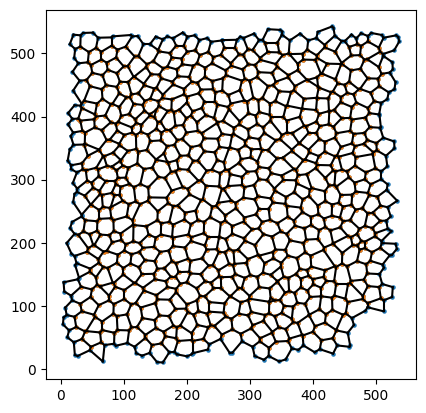

In [441]:
fig, ax=plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(R[:, 0], R[:,1], s=5)
ax.scatter(R[bool_iv][:,0], R[bool_iv][:,1], s=5)

plot_edges(A,R, 'black')

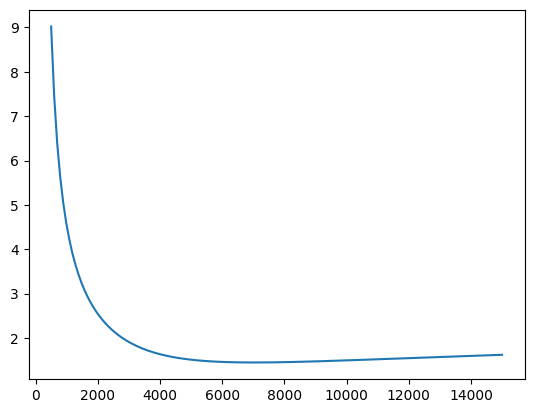

In [45]:
pts=np.linspace(500, 15000, 150)
plt.plot(pts,np.array([objective(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter )for x in pts]))

In [1]:
plt.plot(np.gradient(np.array([objective(x,cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], Gamma, pref_perimeter ) for x in pts[1:]])))
plt.axhline(0)

NameError: name 'plt' is not defined

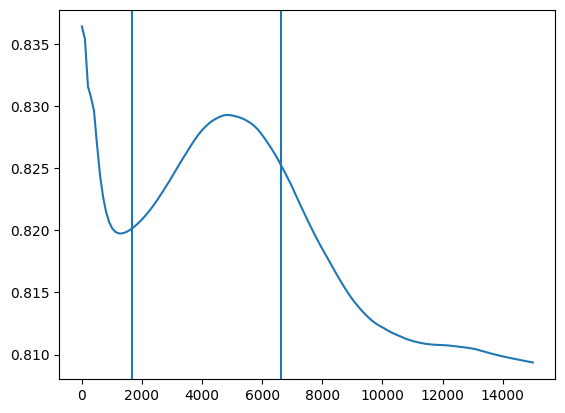

In [49]:
pts=np.linspace(1, 15000, 150)
plt.plot(pts,np.array([np.std(fstar(x, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter ))/np.mean(np.linalg.norm(fstar(x, cell_areas, cell_perimeters, dAdr[:, bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter ), axis=1)) for x in pts]))
plt.axvline(pref_area_P)
plt.axvline(pref_area_fk)

#[np.std(fstar(x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter )) for x in pts]

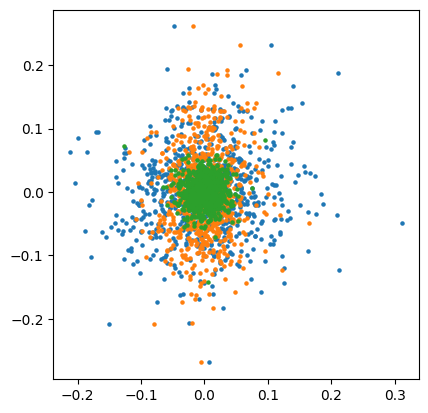

In [304]:
fig, ax=plt.subplots(subplot_kw={'aspect': 'equal'})
ax.scatter(fstar(2000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:, 0], fstar(2000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:,1], s=5)
ax.scatter(fstar(4000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:, 0], fstar(2000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:,1], s=5)

ax.scatter(fstar(12000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:, 0], fstar(12000, cell_areas, cell_perimeters, dAdr[:,bool_iv], dLdr[:,bool_iv], Gamma, pref_perimeter )[:,1], s=5)



In [108]:
cell_areas[cell_areas>np.mean(cell_areas)+3*np.std(cell_areas)]

array([ 897.48044642, 1118.12445067])

In [482]:
fig, ax=plt.subplots(2,2,subplot_kw={'aspect': 'equal'}, figsize=(10,10))

N_e=np.shape(A)[0]
beg_edge = ((abs(A) - A)*0.5)@R
end_edge = ((abs(A) + A)*0.5)@R
for j in range(0,N_e):
    ax[0,0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=1.0,linestyle ='-')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 2., 2., 2., 2., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 3., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       1., 1., 2., 3., 2., 2., 2., 3., 3., 3., 3., 1., 2., 0., 1., 3., 2.,
       1., 2., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 2., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.,
       0., 1., 0., 0., 0.

In [31]:
pref_area_fk_gloe

array([7026.03236609])

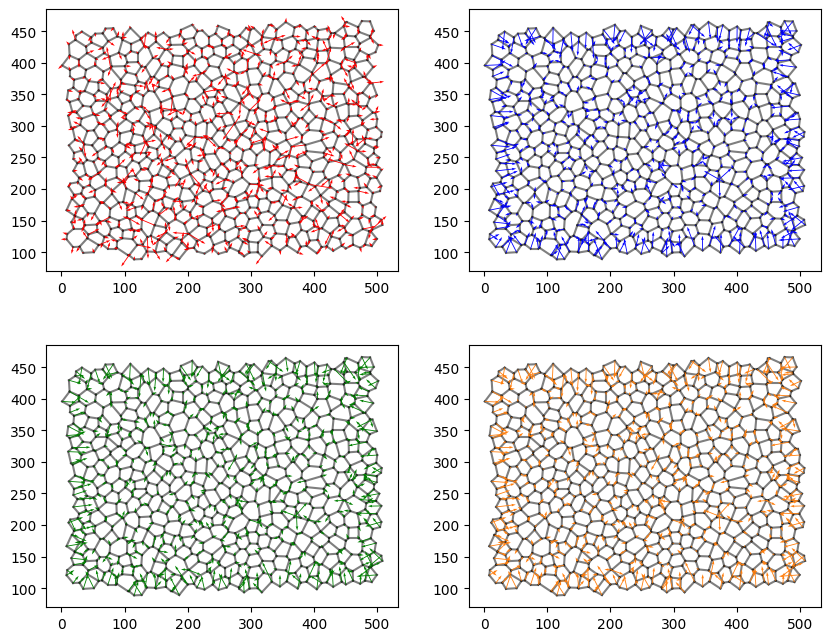

In [30]:
f_fit_P=fstar(pref_area_P, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)
f_fit_T=fstar(pref_area_T, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)

f_fit_f=fstar(pref_area_fk, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)

f_fit_fG=fstar(pref_area_fk_gloe, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter)


fig, ax=plt.subplots(2,2,subplot_kw={'aspect': 'equal'}, figsize=(10,8))

N_e=np.shape(A)[0]
beg_edge = ((abs(A) - A)*0.5)@R
end_edge = ((abs(A) + A)*0.5)@R
for j in range(0,N_e):
    ax[0,0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[0,0].quiver(R[:,0], R[:,1], f_fit_P[:,0], f_fit_P[:,1], color='red')

for j in range(0,N_e):
    ax[0,1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)
ax[0,1].quiver(R[:,0], R[:,1], f_fit_T[:,0], f_fit_T[:,1], color='blue')

for j in range(0,N_e):
    ax[1,0].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[1,0].quiver(R[:,0], R[:,1], f_fit_f[:,0], f_fit_f[:,1], color='green')

for j in range(0,N_e):
    ax[1,1].plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],c='black',alpha=0.5,linestyle ='-',zorder=0)

ax[1,1].quiver(R[:,0], R[:,1], f_fit_fG[:,0], f_fit_fG[:,1], color='tab:orange')


In [38]:
print(mechanics.GlobalStress(pref_area_P, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(pref_area_T, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(pref_area_fk, cell_areas, Gamma, cell_perimeters, pref_perimeter))
print(mechanics.GlobalStress(pref_area_fk_gloe, cell_areas, Gamma, cell_perimeters, pref_perimeter))

3.534808200607436e-17
-1.045766307024543
-0.694848501372953
-0.7282260986308572


In [479]:
print("pref_area_P = ",pref_area_P)
print("pref_area = ",pref_area)
print("pref_area_newton = ",pref_area_newton)
print("resx = ",result.x)
print("res2x = ",result2.x)
print("reslimx = ",result_lim.x)
print("resconstx = ",res_const.x)
print("sol = ",sol.x)

pref_area_P =  1574.0876933520046
pref_area =  [4240.06312414]
pref_area_newton =  10349.838987165671
resx =  [9451.37288049]
res2x =  [47591.61751358]
reslimx =  [7458.47473432]
resconstx =  [4240.06312414]
sol =  [3.76029428e+01 1.60129466e+10]


In [426]:
[np.std(fstar(x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter ))/np.mean(np.linalg.norm(fstar(x, cell_areas, cell_perimeters, dAdr, dLdr, Gamma, pref_perimeter ), axis=1)) for x in pts]

[0.8216938045207003,
 0.8178843716985408,
 0.8167183293180503,
 0.8174194858792845,
 0.8190726563967674,
 0.821289084008148,
 0.8235528486249547,
 0.82563112115317,
 0.827453029103334,
 0.8288875376086033,
 0.8298565105906295,
 0.8303785693654512,
 0.8304284438558286,
 0.8301769680388774,
 0.829725458408676,
 0.8290513047267412,
 0.8281764587213389,
 0.8271762923422097,
 0.8260997344820118,
 0.8249790080603324,
 0.8238088722002699,
 0.822635861466463,
 0.8215002361642554,
 0.8204185424997071,
 0.8193463052082964,
 0.8183105262774535,
 0.8173557340156256,
 0.8164776725224007,
 0.8156774576178123,
 0.8149620878870268,
 0.8143462549839982,
 0.8138340583843173,
 0.8134227953785912,
 0.8131084370494345,
 0.8128864797979075,
 0.8127508486778108,
 0.8126954766931025,
 0.8127201603234668,
 0.8128323994271517,
 0.8130396293134179,
 0.8133448412685771,
 0.8137487457753393,
 0.8142510490953709,
 0.8148504155117767,
 0.8155442526442929,
 0.8163287131375861,
 0.8171987534051163,
 0.8181439723221424

In [425]:
[ for x in pts]

[0.39136307677080057,
 0.3238762378842808,
 0.2775244583834478,
 0.243647467848734,
 0.2178212395590464,
 0.19744444095836333,
 0.18098547625503872,
 0.1674207611001734,
 0.15604263896945617,
 0.1463746516765231,
 0.1380703048680812,
 0.13086181547261042,
 0.12455525159984804,
 0.11897466630510758,
 0.11399144560457553,
 0.10951959227653328,
 0.10548469958001964,
 0.10181967545394129,
 0.09847212392885991,
 0.09540023077468325,
 0.09257302016273151,
 0.08995870769786408,
 0.08753067791818377,
 0.08526839086999327,
 0.08316024376702895,
 0.08118926152547255,
 0.07933881150896077,
 0.07759876100494548,
 0.0759596860590187,
 0.07441269284240928,
 0.07294915238772774,
 0.07156223935125058,
 0.07024640526616795,
 0.06899677253137489,
 0.06780898212248138,
 0.06667922036792645,
 0.0656040304189298,
 0.06457980459504024,
 0.06360263957505974,
 0.0626689459677196,
 0.06177574778458775,
 0.06092046792436388,
 0.06010079884453762,
 0.05931468078142084,
 0.058560295325722114,
 0.05783604492601153

In [370]:
np.max(abs(dAdr.sum(axis=1)))

5.329070518200751e-15

In [372]:
def objdAdr(A0, dAdr):
    return (1/np.sqrt(A0)*dAdr)

In [374]:
objdAdr(pref_area, dAdr)

array([[[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       ...,

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]])

In [373]:
ls_dAdr=optimize.least_squares(objdAdr,1000,args=(dAdr), loss='soft_l1', jac='3-point')

TypeError: objdAdr() takes 2 positional arguments but 530 were given

In [114]:
[objective(x, cell_areas, cell_perimeters, dAdr[:, bool_iv], dLdr[:, bool_iv], Gamma, pref_perimeter) for x in [1000, 2000, 3000]]

[7.179256276550369, 4.119908602726379, 2.939215470724768]

In [154]:
np.mean(cell_areas/1353)

0.26927205111733804

In [420]:
pref_area=res_const.x

In [422]:
    R_nd=R/((pref_area)**0.5)
    areas_nd=cell_areas/pref_area
    perimeters_nd=cell_perimeters/((pref_area)**0.5)
    tangents_nd=geometry.get_tangents(A,R_nd)
    edge_lengths_nd=geometry.get_edge_lengths(tangents_nd)
    cell_centres_nd=geometry.get_cell_centres(C,R_nd,cell_edge_count)
    cell_centres_nd=geometry.get_cell_centres(C,R_nd,cell_edge_count)

In [423]:
    N_c=np.shape(C)[0]
    cell_id=np.linspace(0, N_c-1,N_c)
    cell_P_eff = mechanics.get_P_eff(areas_nd, Gamma, perimeters_nd, pref_perimeter) 
    cell_pressures = mechanics.get_cell_pressures(areas_nd)
    cell_tensions = mechanics.get_cell_tensions(Gamma, perimeters_nd, pref_perimeter)
    cell_shears,cell_zetas = mechanics.calc_shear(tangents_nd,edge_lengths_nd,B,perimeters_nd,cell_tensions,areas_nd)
    cell_circularity, major_shape_axis, major_shape_axis_alignment,major_stress_axis, major_stress_axis_alignment=geometry.get_shape_tensor(R_nd,C,cell_edge_count,cell_centres_nd,cell_P_eff)
    shape_parameter = perimeters_nd/(np.sqrt(areas_nd))

    global_stress= mechanics.get_global_stress(cell_P_eff, areas_nd)
    monolayer_energy=mechanics.get_monolayer_energy(areas_nd, perimeters_nd, pref_perimeter)



    #combine data into a dataframe object
    data_names=['cell_id', 'cell_perimeter_microns', 'cell_area_microns', 'cell_perimeter_nd',\
    'cell_area_nd', 'cell_P_eff_nd', 'shape_parameter', 'circularity', 'cell_edge_count', \
    'cell_shear', 'cell_zeta', 'major_shape_axis_alignment_rads', 'major_stress_axis_alignment_rads']
    cell_data_all=np.transpose(np.vstack((cell_id, cell_perimeters, cell_areas, perimeters_nd, areas_nd,\
    cell_P_eff, shape_parameter, cell_circularity, cell_edge_count, cell_shears, cell_zetas, major_shape_axis_alignment, major_stress_axis_alignment)))

    cell_df=pd.DataFrame(cell_data_all, columns=data_names) 

    #Only geometric data (no Gamma or Lambda dependence)
    geom_data_names=['cell_id', 'cell_perimeter_microns', 'cell_area_microns', 'shape_parameter', 'circularity', 'cell_edge_count', \
    'major_shape_axis_alignment_rads']
    cell_data_geom=np.transpose(np.vstack((cell_id, cell_perimeters, cell_areas,\
    shape_parameter, cell_circularity, cell_edge_count, major_shape_axis_alignment)))

    geom_df=pd.DataFrame(cell_data_geom, columns=geom_data_names)


In [424]:
edge_tensions=abs(B).T @cell_tensions

In [96]:
np.min(edge_tensions)

-0.041481299405511665

In [33]:
cm.rainbow(edge_tensions[1])

(0.46862745098039216, 0.04925994109281685, 0.9996964519778716, 1.0)

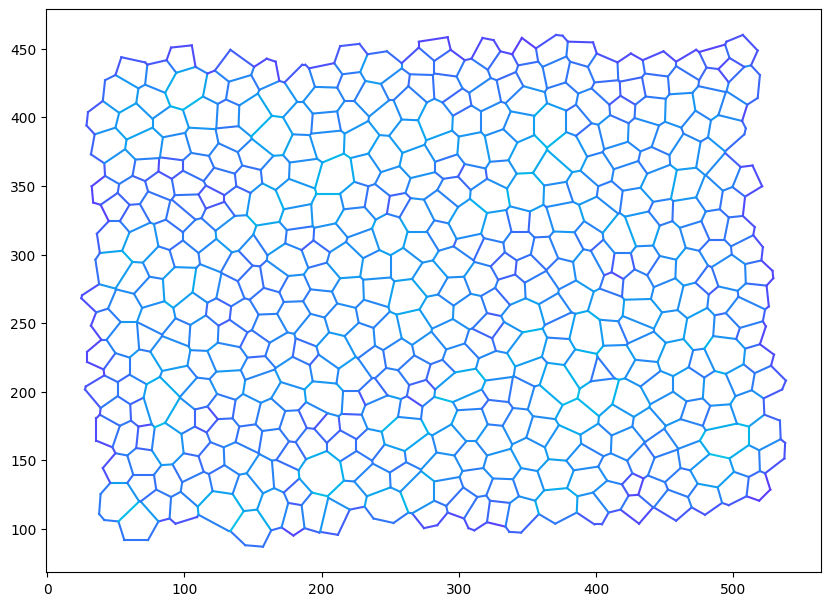

In [425]:
fig, ax=plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(10,10))

N_e=np.shape(A)[0]
beg_edge = ((abs(A) - A)*0.5)@R
end_edge = ((abs(A) + A)*0.5)@R
for j in range(0,N_e):
    ax.plot([beg_edge[j,0],end_edge[j,0]],[beg_edge[j,1],end_edge[j,1]],color=cm.rainbow((edge_tensions[j]+0.05)))

In [426]:
    #write data frames and summary stats
    cell_df.to_csv(save_dir + '/'+exp_id+'_cell_data_all_Gamma_'+str(Gamma)+'_Lambda_'+str(Lambda)+'.csv', index=False)
    cell_df.iloc[:,1:].describe().to_csv(save_dir + '/'+exp_id+'_summary_stats_Gamma_'+str(Gamma)+'_Lambda_'+str(Lambda)+'.csv')

    geom_df.to_csv(save_dir + '/'+exp_id+'_cell_data_geometry.csv', index=False)
    geom_df.iloc[:,1:].describe().to_csv(save_dir + '/'+exp_id+'_geometry_summary_stats.csv')

    fileio.write_global_data(global_stress, monolayer_energy, save_dir,edges_name) #write global data



In [427]:


    ##############################
    #Plot
    ##############################
    print("Generating Plots")
    ### Distributions ###

    #Summary Histograms for continuous data 
    visualise.plot_summary_hist(cell_df,'all_data', save_dir, edges_name)
    visualise.plot_summary_hist(geom_df,'geom_data', save_dir, edges_name)

    #discrete data
    visualise.plot_cell_sides(cell_df, "Number_of_Sides", save_dir, edges_name)

    #angle histogram
    visualise.angle_hist(cell_df['major_shape_axis_alignment_rads'], "Major Shape Axis Alignment", save_dir, 12, 180 , edges_name)
    visualise.angle_hist(cell_df['major_stress_axis_alignment_rads'], "Major Stress Axis Alignment", save_dir, 12, 180 , edges_name)
    ##### Network Plots ####
    axisLength = np.max(abs(R))+10

    ### Gradient plots ###
    #numbered plot for reference


    # Area #
    visualise.graphNetworkColorBar('Cell Areas',cell_areas,'Greens',0,0,1400,\
    t,A,C,R,cell_centres,axisLength,save_dir,edges_name,1,0, 'png')

    # # Number of sides #  #NB colorbar will need adjusting for any oficial figures
    # visualise.graphNetworkColorBar('Number of Sides',cell_edge_count,'Paired',1,4.0,11.0,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # # Circularity #
    # visualise.graphNetworkColorBar('Circularity',cell_circularity,'viridis',1,0.0,1.0,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # visualise.graphNetworkColorBar('Elongation',1.0-cell_circularity,'viridis',1,0.0,1.0,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # # Shear Strain #
    # visualise.graphNetworkColorBar('Shear Strain',cell_zetas,'viridis',-1,0.0,0.35,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # # Cell effective pressures # (bare in mind forcing limits maybe necessary for nice symmetry round 0)
    # visualise.graphNetworkColorBar('Absolute Effective Pressure',abs(cell_P_eff),'plasma',1,0.0,0.5,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # visualise.graphNetworkColorBar('Effective Pressure',cell_P_eff,'bwr',1,-1.0,1.0,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # Shear Stress
    visualise.graphNetworkColorBar('Shear Stress',cell_shears,'plasma',-1,0.0,0.7,\
    t,A,C,R,cell_centres,axisLength,save_dir,edges_name,1,0, 'png')

    # # Cell Tension and Pressure
    # visualise.graphNetworkColorBar('Cell Tension',cell_tensions,'inferno',-1,0.0,0.5,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # visualise.graphNetworkColorBar('Cell Pressure',cell_pressures,'cividis',-1,0.0,0.5,\
    # t,A,C,R,cell_centres,axisLength,plot_dir,edges_name,ExperimentFlag,0, 'png')

    # #### Binary Plots ###

    # # Areas #
    # visualise.graphNetworkColourBinary('Cell Areas Binary',cell_areas,'darkgreen','palegreen',np.median(cell_areas),0,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    # #Number of sides
    # visualise.graphNetworkColourBinary('Number Of Sides Binary',cell_edge_count,'darkorchid','thistle',np.median(cell_edge_count),0,1,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    # #Circularity#
    # visualise.graphNetworkColourBinary('Cell Circularity Binary',cell_circularity,'darkorange','bisque',2.0/3.0,0,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    # visualise.graphNetworkColourBinary('Cell Elongation Binary',1.0-cell_circularity,'crimson','pink',2.0/3.0,0,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    # # Shear Strain
    # visualise.graphNetworkColourBinary('Shear strain Binary',cell_zetas,'hotpink','gold',np.median(cell_zetas),1,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    # # Effective pressure
    # visualise.graphNetworkColourBinary('Magnitude of effective pressure Binary',abs(cell_P_eff),'yellow','lemonchiffon',np.median(abs(cell_P_eff)),1,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

    visualise.graphNetworkColourBinary('Effective Pressure Binary',cell_P_eff,'red','blue',0,1,0,\
    t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,save_dir,edges_name,1,0, 'black', 'png')

    
    visualise.graphNetworkColourBinary('Cell_id',cell_df['cell_id'],'black','black',0.0,0,0,t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,save_dir,edges_name,1, 1, 'blue','png')
    # #Shear Stress
    # visualise.graphNetworkColourBinary('Cell Shears Binary',cell_shears,'darkseagreen','honeydew',np.mean(cell_shears),0,0,\
    # t,A,C,R,cell_centres,cell_P_eff,major_stress_axis,axisLength,plot_dir,edges_name,ExperimentFlag, 'png')

Generating Plots


In [382]:
8100/60

135.0

In [54]:
np.sum((perimeters_nd*(perimeters_nd-pref_perimeter))[:, None, None]*J, axis=0)

array([[ 0.06071739, -0.07225201],
       [-0.07225201, -0.06071739]])

In [55]:
pref_area=np.linalg.det(np.sum((cell_perimeters*cell_perimeters)[:, None, None]*J, axis=0))/((pref_perimeter*pref_perimeter)*np.linalg.det(np.sum((cell_perimeters)[:, None, None]*J, axis=0)))

In [67]:
1/(pref_area) * np.linalg.det(np.sum((perimeters_nd*(perimeters_nd))[:, None, None]*J, axis=0))

-0.001798874050047934

In [70]:
(pref_perimeter**2)*np.linalg.det(np.sum((perimeters_nd)[:, None, None]*J_nd, axis=0))

-22.313183695238703

In [71]:
1/(pref_area) * np.linalg.det(np.sum((perimeters_nd*(perimeters_nd))[:, None, None]*J_nd, axis=0))

-0.0017988740500479365

In [72]:
J

array([[[ 0.06589245, -0.12845234],
        [-0.12845234, -0.06589245]],

       [[-0.03564618, -0.05144211],
        [-0.05144211,  0.03564618]],

       [[ 0.11107384, -0.02804492],
        [-0.02804492, -0.11107384]],

       ...,

       [[ 0.02382883,  0.15124633],
        [ 0.15124633, -0.02382883]],

       [[ 0.08138515,  0.12307617],
        [ 0.12307617, -0.08138515]],

       [[ 0.04571293, -0.09386888],
        [-0.09386888, -0.04571293]]])

In [73]:
J_nd

array([[[ 0.06589245, -0.12845234],
        [-0.12845234, -0.06589245]],

       [[-0.03564618, -0.05144211],
        [-0.05144211,  0.03564618]],

       [[ 0.11107384, -0.02804492],
        [-0.02804492, -0.11107384]],

       ...,

       [[ 0.02382883,  0.15124633],
        [ 0.15124633, -0.02382883]],

       [[ 0.08138515,  0.12307617],
        [ 0.12307617, -0.08138515]],

       [[ 0.04571293, -0.09386888],
        [-0.09386888, -0.04571293]]])

In [57]:
    R_nd=R/((pref_area)**0.5)
    areas_nd=cell_areas/pref_area
    perimeters_nd=cell_perimeters/((pref_area)**0.5)

In [69]:
tangents_nd=geometry.get_tangents(A,R_nd)
edge_lengths_nd=geometry.get_edge_lengths(tangents_nd)
Q_nd,J_nd=mechanics.get_Q_J(tangents_nd, edge_lengths_nd, B,perimeters_nd)

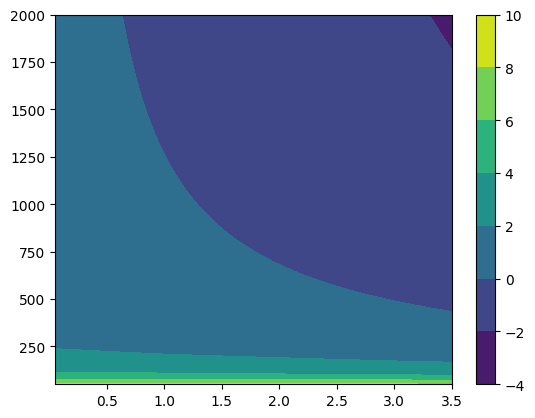

In [63]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(50,2000, 50 )
Z=np.array([[mechanics.GlobalStress(y, cell_areas, Gamma,cell_perimeters,x ) for x in X] for y in Y])
plt.contourf(X,Y, Z, levels=5)
plt.colorbar()

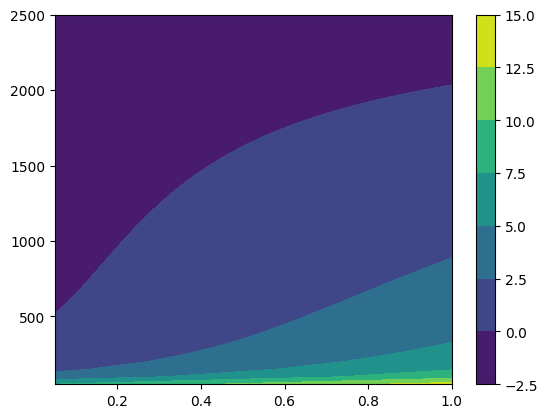

In [69]:
X=np.linspace(0.05, 1, 50)
Y=np.linspace(50,2500, 50 )
Z=np.array([[mechanics.GlobalStress(y, cell_areas, x,cell_perimeters,1.5 ) for x in X] for y in Y])
plt.contourf(X,Y, Z, levels=5)
plt.colorbar()

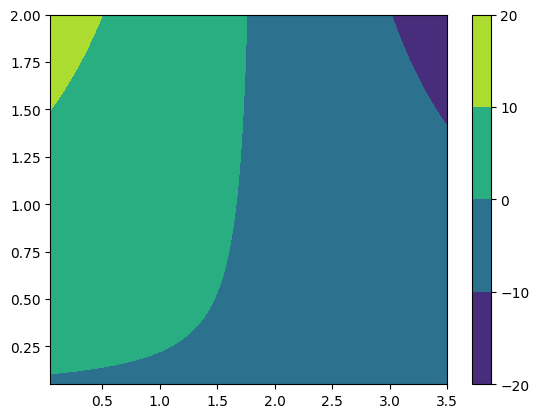

In [81]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=np.array([[mechanics.GlobalStress(pref_area_P, cell_areas, y,cell_perimeters,x ) for x in X] for y in Y])
plt.contourf(X,Y, Z, levels=2)
plt.colorbar()

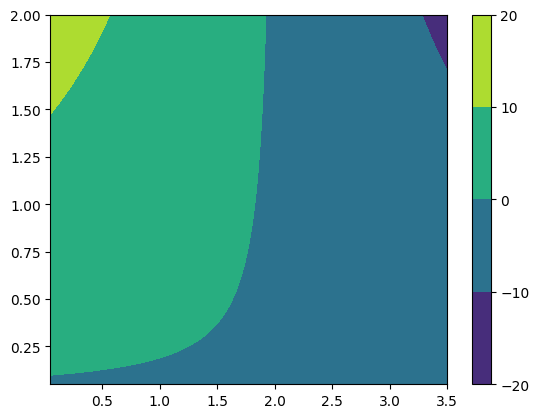

In [152]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=np.array([[mechanics.GlobalStress(1353, cell_areas, y,cell_perimeters,x ) for x in X] for y in Y])
plt.contourf(X,Y, Z, levels=2)
plt.colorbar()

In [ ]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area) for x in X] for y in Y]

In [74]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=np.linspace(50, 2000,50 )

G=[[[mechanics.GlobalStress(z, cell_areas, y, cell_perimeters, x) for x in X] for y in Y] for z in Z]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (50,) and arg 2 with shape (2500,).

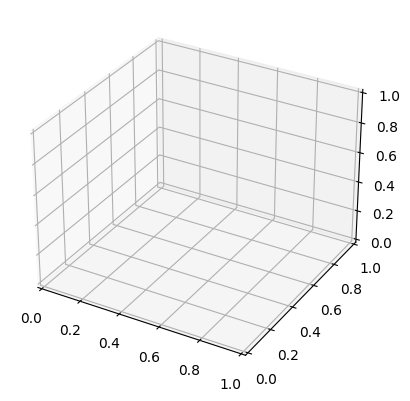

In [84]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X,Y, Z, color=G)

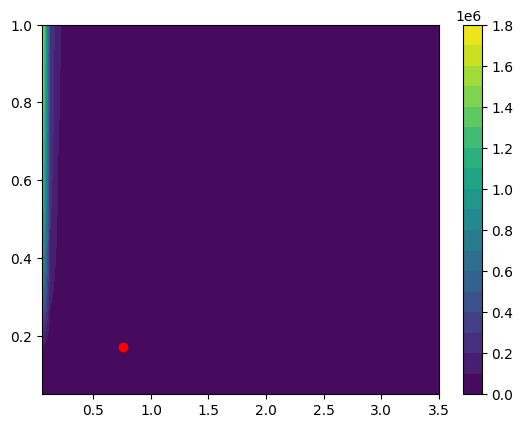

In [110]:
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,1, 50 )
Z=[[geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area) for x in X] for y in Y]
plt.contourf(X,Y, Z, levels=20)
plt.colorbar()
plt.scatter([pref_perimeter], [Gamma], c='r')

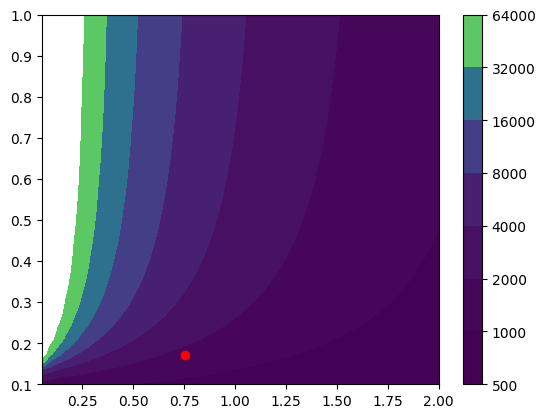

In [115]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 2, 50)
Y=np.linspace(0.1,1, 50 )
Z=[[geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area) for x in X] for y in Y]
im=ax.contourf(X,Y, Z, levels=[500, 1000, 2000, 4000, 8000, 16000, 32000, 64000])
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')

plt.show()

In [1]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[np.mean(cell_areas/geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area)) for x in X] for y in Y]
im=ax.contourf(X,Y, Z)
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')
plt.xlabel("L_0")
plt.ylabel("Gamma")

plt.show()



NameError: name 'plt' is not defined

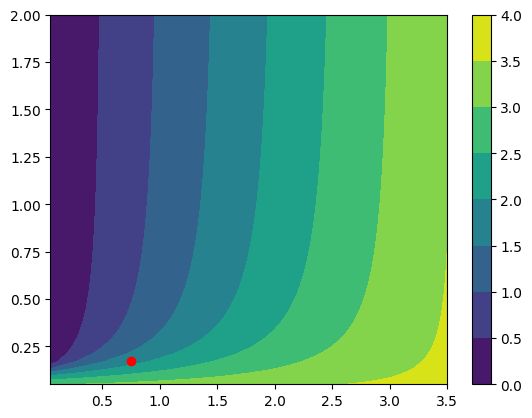

In [131]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[np.mean(cell_perimeters/np.sqrt(geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area))) for x in X] for y in Y]
im=ax.contourf(X,Y, Z)
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')

plt.show()

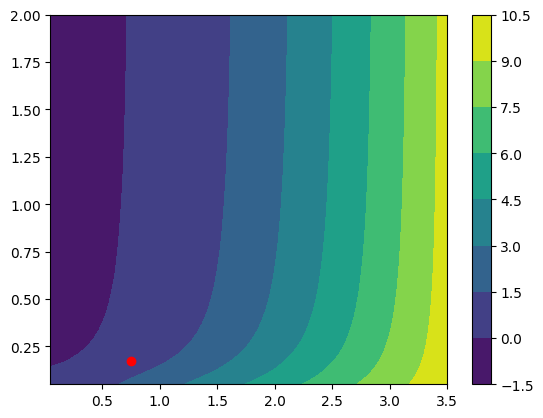

In [134]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[np.mean(x*(cell_perimeters/np.sqrt(geometry.get_pref_area(cell_areas, y, cell_perimeters, x, mean_cell_area))-pref_perimeter)) for x in X] for y in Y]
im=ax.contourf(X,Y, Z)
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')

plt.show()

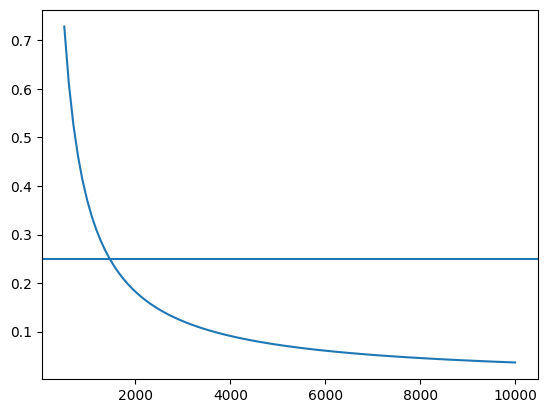

In [143]:
plt.plot(np.linspace(500, 10001, 100),np.array([np.mean(cell_areas/x) for x in np.linspace(500, 10001, 100)]))

plt.axhline(0.25)

C:\Users\v35431nc\AppData\Local\Temp\ipykernel_36772\96290194.py:2: RuntimeWarning: divide by zero encountered in divide
  return (1/np.sqrt(A0))*np.tensordot((Ai/A0 -1), dAdr, axes=1) + np.tensordot(Gamma*(Li/np.sqrt(A0) - L0), dLdr, axes=1)


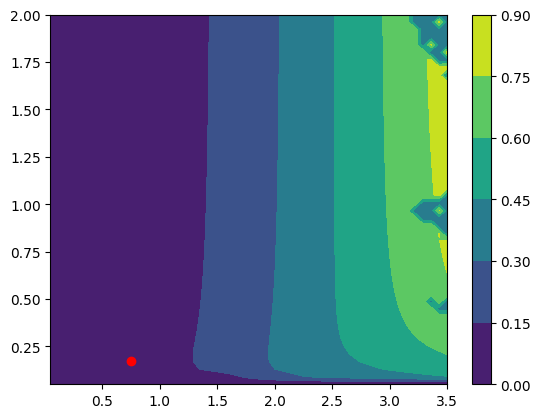

In [130]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[np.mean(cell_areas/optimize.minimize(objective_sq, x0=1000, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], y, x),bounds=optimize.Bounds(lb=0, ub=20000)).x) for x in X] for y in Y]
im=ax.contourf(X,Y, Z)
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')

plt.show()

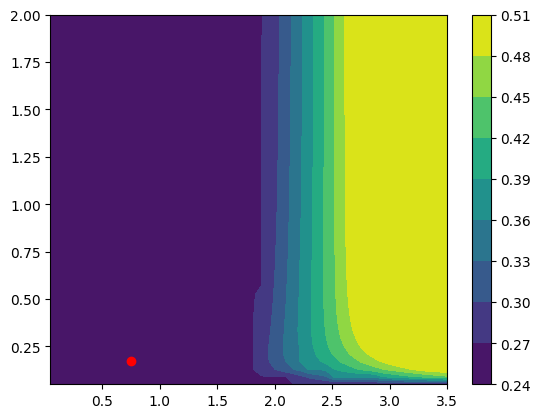

In [133]:
fig, ax=plt.subplots()
X=np.linspace(0.05, 3.5, 50)
Y=np.linspace(0.05,2, 50 )
Z=[[np.mean(cell_areas/optimize.minimize(objective_sq, x0=1000, args=( cell_areas[intcells], cell_perimeters[intcells], dAdr[:, bool_iv][intcells], dLdr[:, bool_iv][intcells], y, x),bounds=optimize.Bounds(lb=0, ub=20000), constraints=[nlcP, nlcT]).x) for x in X] for y in Y]
im=ax.contourf(X,Y, Z)
plt.colorbar(im)
ax.scatter([pref_perimeter], [Gamma], c='r')

plt.show()